In [65]:
import numpy as np
import matplotlib.pylab as plt
from scipy.fftpack import fft, fftfreq, ifft
from datetime import datetime, timedelta
from scipy import signal

In [66]:
sample_rate         = 32000     #Hz

M1_amplifier_dB     = 26.       #dB
M3_amplifier_dB     = 32.       #dB
M1_sensitivity_dB   = -165.     #dB re 1V/µPa
M3_sensitivity_dB   = -170.     #dB re 1V/µPa

station             = 'M1'
                            # ( year, month, day, hour, min, sec, microsecond)
start_time          = datetime( 2014,     6,  24,    5,   0,   0 )
end_time            = datetime( 2014,     6,  24,    5,  10,   0 )

freq_band           = [4000, 10000] #Hz

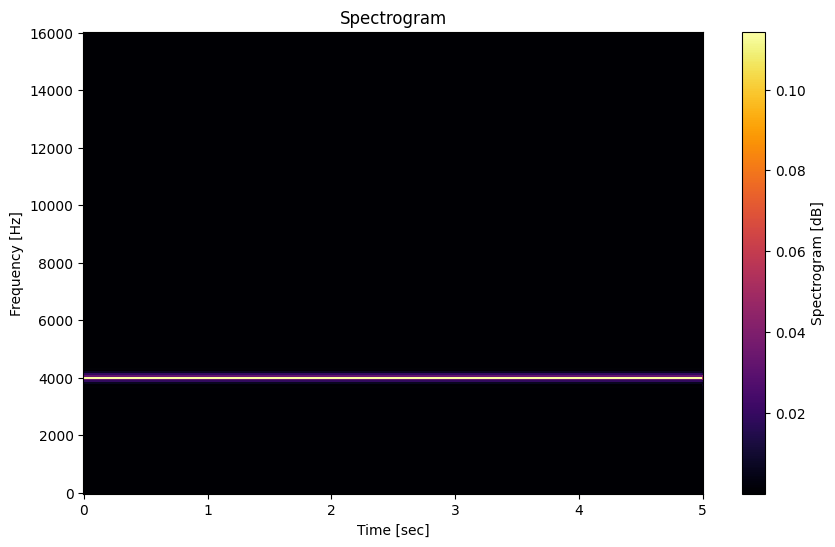

0.11430368850207608


In [67]:
amplitude_test = 2.0  # Амплитуда
frequency_test = 4000.0  # Частота (в герцах)
duration_test = 5     # Продолжительность сигнала в секундах
sampling_rate_test = 32000 # Частота дискретизации (точек в секунду)
time_test = np.linspace(0, duration_test, duration_test * sampling_rate_test, endpoint=False)
test = amplitude_test * np.sin(2 * np.pi * frequency_test * time_test)

window_size  = 512
window = signal.windows.tukey(window_size, alpha=0.5)
window /= window.sum()

f_test, t_test, Zxx_test = signal.stft(test, sampling_rate_test, window=window, scaling='psd',nperseg=512)

plt.figure(figsize=(10, 6))
plt.pcolormesh(t_test, f_test, np.abs(Zxx_test), cmap = 'inferno')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Spectrogram [dB]')
plt.title('Spectrogram')
plt.show()

print(max(item for sublist in np.abs(Zxx_test) for item in sublist))

In [68]:
duration = end_time - start_time
files_num = int(np.ceil(duration.seconds / 600))

def file_name(station, start, end):
    return f'{station}_{start.day:02d}{start.month:02d}{start.hour:02d}{start.minute:02d}-{end.day:02d}{end.month:02d}{end.hour:02d}{end.minute:02d}.dat'

current_time = start_time
samples = np.zeros(600 * sample_rate)
data_arrays = []

for i in range(files_num):
    next_time = start_time + timedelta(minutes = 10)
    with open(file_name(station, current_time, next_time), 'r') as fID:
        samples = np.fromfile(fID, np.int16).astype(np.float32)
        data_arrays.append(samples)
    continue_time = next_time

data_array_V = np.concatenate(data_arrays)

constant = (M1_sensitivity_dB + M1_amplifier_dB) * (station == 'M1') + (M3_sensitivity_dB + M3_amplifier_dB) * (station == 'M3')

# time = np.linspace(start_time, end_time, duration.seconds * sample_rate)

In [69]:
data_sos = signal.butter(32, freq_band, 'bandpass', fs=sample_rate, output='sos')
# butter(N, Wn, btype='low', analog=False, output='ba', fs=None) second-order sections (‘sos’)
data = signal.sosfiltfilt(data_sos, data_array_V)

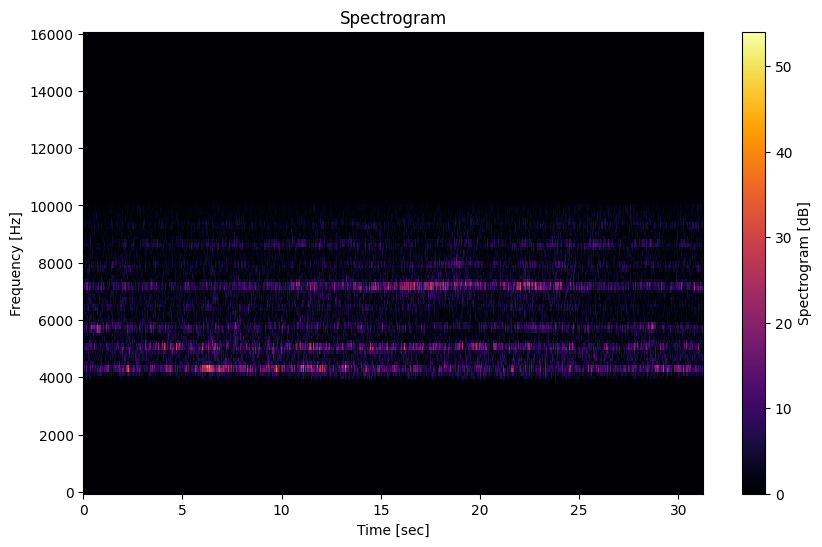

In [70]:
f, t, Zxx = signal.stft(data[:1000000], sample_rate, scaling='psd')

plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, np.abs(Zxx), cmap = 'inferno')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Spectrogram [dB]')
plt.title('Spectrogram')
plt.show()